# Vision Transformer (ViT)
In this notebook, we build a vision transformer for digit recognition trained on the MNIST dataset. We used [Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/versions/2022/transformer/python/transformer_demo.ipynb), [PyTorch Image Models (timm)](https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py), and [Vision Transformer for Image Classification](https://www.youtube.com/watch?v=HZ4j_U3FC94) as reference.

In [6]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from einops import rearrange
from argparse import ArgumentParser
from PIL import Image

One of the core principles of Transformers is its self-attention module. This is used to determine which parts of our input sequence are most important or relevant in solving the task at hand. In vision transformers, we use visual attention for the model to determine which parts of the image are important in properly classifying the input into its corresponding digit. The $Attention$ class in the following code block is designed to perform the self-attention module of our vision transformer.

In [7]:
class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, qkv_bias=False, qk_norm=False, norm_layer=nn.LayerNorm):
        super().__init__()
        assert embed_dim % num_heads == 0, 'embedding dimension must be divisible by number of heads'
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(self.embed_dim, self.embed_dim*3, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, x):
        '''
            B: batch size
            N: number of patches
            C: flattened input vector
        '''
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        q *= self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

After the self-attention module, the data is then fed into a feed-forward neural network (or a multilayer perceptron). The $MultilayerPerceptron$ class is used to build the MLP layer of our encoder.

In [8]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        out_features = out_features or in_features # equivalent to out_features = out_features if out_features else in_features
        hidden_features = hidden_features or in_features # equivalent to hidden_features = hidden_features if hidden_features else in_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.act = act_layer()
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()
        self.fc2 = nn.Linear(in_features=hidden_features, out_features=out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.norm(x)
        x = self.fc2(x)
        return x

The combination of the multiheaded self-attention and the feed-forward neural network builds a single transformer block. The $Block$ class combines these two modules to build a single transformer block.

In [9]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, qkv_bias=False, qk_norm=True, act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm = norm_layer(embed_dim)
        self.attn = Attention(embed_dim=embed_dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_norm=qk_norm, norm_layer=nn.LayerNorm)
        self.mlp = MultilayerPerceptron(in_features=embed_dim, hidden_features=int(embed_dim*mlp_ratio), out_features=embed_dim, act_layer=act_layer)

    def forward(self, x):
        x = self.norm(x)
        x += self.attn(x)
        x = self.norm(x)
        x += self.mlp(x)
        return x

The transformer encoder is usually made of various transformer blocks. Thus, the $Encoder$ class initializes these transformer blocks and feeds the data into the model block by block.

In [10]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_blocks, mlp_ratio=4, qkv_bias=False, qk_norm=True, act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, mlp_ratio, qkv_bias, qk_norm, act_layer, norm_layer) for _ in range(num_blocks)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

The $init\_weights\_vit\_timm$ function is used in timm to help initialize the weights, which would help boost the performance of our model.

In [11]:
def init_weights_vit_timm(module: nn.Module):
    if isinstance(module, nn.Linear):
        nn.init.trunc_normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif hasattr(module, 'init_weights'):
        module.init_weights()

While the vision transformer is largely based on the transformer architecture that is originally used for natural language processing (NLP) tasks, they still have some key differences. One key difference between the two is that the vision transformer typically leverages the transformer encoder part only and does not include the decoder in performing vision tasks. Thus, as seen in the $VisionTransformer$ class, we only include the transformer encoder part in our model.

In [12]:
class VisionTransformer(LightningModule):
    def __init__(self, num_classes=10, lr=0.001, max_epochs=30, depth=12, embed_dim=64, head=4, patch_dim=49, seqlen=16, pos_embed=True):
        super().__init__()
        self.train_step_outputs = []
        self.test_step_outputs = []
        self.save_hyperparameters()

        self.in_proj = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, seqlen, embed_dim) * .02) if pos_embed else 0
        self.encoder = Encoder(embed_dim=embed_dim, num_heads=head, num_blocks=depth, mlp_ratio=4, qkv_bias=False, qk_norm=True, act_layer=nn.GELU, norm_layer=nn.LayerNorm)
        self.fc = nn.Linear(seqlen*embed_dim, num_classes)
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.reset_parameters()

    def reset_parameters(self):
        init_weights_vit_timm(self)

    def forward(self, x):
        x = self.in_proj(x)
        x += self.pos_embed

        x = self.encoder(x)
        x = x.flatten(start_dim=1)

        x = self.fc(x)
        return x
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.train_step_outputs.append({"loss": loss})
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.stack([x["loss"] for x in self.train_step_outputs]).mean()
        self.train_step_outputs.clear()
        print(f'| Train loss: {avg_loss}')
        self.log("train_loss", avg_loss, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        acc = self.accuracy(y_hat, y) * 100.
        self.test_step_outputs.append({"y_hat": y_hat, "test_loss": loss, "test_acc": acc})
        return y_hat, loss, acc
    
    def on_test_epoch_end(self):
        avg_loss = torch.stack([x["test_loss"] for x in self.test_step_outputs]).mean()
        avg_acc = torch.stack([x["test_acc"] for x in self.test_step_outputs]).mean()
        self.test_step_outputs.clear()
        print(f'| Test loss: {avg_loss}', end=' | ')
        print(f'Test accuracy: {avg_acc}')
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", avg_acc, on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()

We use PyTorch's LightningDataModule to setup the data that we will use for training and testing our vision transformer model. In this module, we split the image into patches in order for the data to be suitable for a transformer model.

In [13]:
class LitMNIST(LightningDataModule):
    def __init__(self, batch_size=64, num_workers=4, patch_num=4):
        super().__init__()
        self.batch_size = batch_size
        self.patch_num = patch_num
        self.num_workers = num_workers

    def prepare_data(self):
        self.train_set = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
        self.test_set = torchvision.datasets.MNIST('./data', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())

    def collate_fn(self, batch):
        x, y = zip(*batch)
        x = torch.stack(x, dim=0)
        y = torch.LongTensor(y)
        x = rearrange(x, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=self.patch_num, p2=self.patch_num)
        return x, y
    
    # Settings from https://nextjournal.com/gkoehler/pytorch-mnist
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, 
                                           collate_fn=self.collate_fn, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_set, batch_size=self.batch_size, shuffle=False, 
                                           collate_fn=self.collate_fn, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return self.test_dataloader()

After setting up the model, the datasets, and the train/test/validation configurations, we set up the arguments.

In [14]:
def get_args():
    parser = ArgumentParser(description='Vision Transformer')
    parser.add_argument('--depth', type=int, default=12, help='depth')
    parser.add_argument('--embed_dim', type=int, default=32, help='embedding dimension')
    parser.add_argument('--num_heads', type=int, default=4, help='num_heads')

    parser.add_argument('--pos_embed', type=bool, default=True, help='add positional embedding')
    parser.add_argument('--patch_num', type=int, default=4, help='patch_num')
    parser.add_argument('--batch_size', type=int, default=32, metavar='N',
                        help='input batch size for training (default: 32)')
    parser.add_argument('--max-epochs', type=int, default=30, metavar='N',
                        help='number of epochs to train (default: 30)')
    parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                        help='learning rate (default: 0.001)')

    parser.add_argument('--accelerator', default='gpu', type=str, metavar='N')
    parser.add_argument('--devices', default=1, type=int, metavar='N')
    parser.add_argument('--num_workers', default=0, type=int, metavar='N')
    parser.add_argument("--path", default="models", help="Model save path")
    args = parser.parse_args("")
    return args

Now, we train the ViT model with the MNIST dataset.

In [15]:
if __name__ == '__main__':
    args = get_args()
    datamodule = LitMNIST(batch_size=args.batch_size, patch_num=args.patch_num, num_workers=args.num_workers*args.devices)
    datamodule.prepare_data()

    data = next(iter(datamodule.train_dataloader()))
    patch_dim = data[0].shape[-1]
    seqlen = data[0].shape[-2]
    print(f'Patch Dimension: {patch_dim}')

    model = VisionTransformer(num_classes=10, lr=args.lr, max_epochs=args.max_epochs, depth=args.depth, embed_dim=args.embed_dim, 
                              head=args.num_heads, patch_dim=patch_dim, seqlen=seqlen, pos_embed=args.pos_embed)
    
    model_checkpoint = ModelCheckpoint(
        dirpath=os.path.join(args.path, "checkpoints"),
        filename="mnist-vit-best-acc",
        save_top_k=1,
        verbose=True,
        monitor='test_acc',
        mode='max')
    
    trainer = Trainer(accelerator=args.accelerator, devices=args.devices, max_epochs=args.max_epochs,
                      precision=16 if args.accelerator=='gpu' else 32, callbacks=model_checkpoint)
    trainer.fit(model=model, datamodule=datamodule)
    trainer.test(model=model, datamodule=datamodule)

    model = model.load_from_checkpoint(os.path.join(args.path, "checkpoints", "mnist-vit-best-acc.ckpt"))
    model.eval()
    script = model.to_torchscript()
    model_path = os.path.join(args.path, "checkpoints", "mnist-vit-best-acc.pt")
    torch.jit.save(script, model_path)

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning_fabric\connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Patch Dimension: 49


c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | in_proj  | Linear             | 1.6 K 
1 | encoder  | Encoder            | 153 K 
2 | fc       | Linear             | 5.1 K 
3 | loss     | CrossEntropyLoss   | 0     
4 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
161 K     

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s]

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]| Test loss: 2.6062469482421875 | Test accuracy: 7.8125
                                                                           

c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1875/1875 [01:17<00:00, 24.22it/s, v_num=0, test_loss=0.193, test_acc=94.20]| Train loss: 0.2957986891269684


Epoch 0, global step 1875: 'test_acc' reached 94.23921 (best 94.23921), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 1: 100%|██████████| 1875/1875 [01:16<00:00, 24.64it/s, v_num=0, test_loss=0.116, test_acc=96.40]| Train loss: 0.17082171142101288


Epoch 1, global step 3750: 'test_acc' reached 96.37579 (best 96.37579), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 2: 100%|██████████| 1875/1875 [01:14<00:00, 25.08it/s, v_num=0, test_loss=0.123, test_acc=96.30]| Train loss: 0.1381990760564804


Epoch 2, global step 5625: 'test_acc' was not in top 1


Epoch 3: 100%|██████████| 1875/1875 [01:17<00:00, 24.27it/s, v_num=0, test_loss=0.114, test_acc=96.20]| Train loss: 0.11903229355812073


Epoch 3, global step 7500: 'test_acc' was not in top 1


Epoch 4: 100%|██████████| 1875/1875 [01:17<00:00, 24.17it/s, v_num=0, test_loss=0.0981, test_acc=97.00]| Train loss: 0.10154708474874496


Epoch 4, global step 9375: 'test_acc' reached 97.04472 (best 97.04472), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 5: 100%|██████████| 1875/1875 [01:16<00:00, 24.64it/s, v_num=0, test_loss=0.0859, test_acc=97.10]| Train loss: 0.08863012492656708


Epoch 5, global step 11250: 'test_acc' reached 97.12460 (best 97.12460), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 6: 100%|██████████| 1875/1875 [01:15<00:00, 24.73it/s, v_num=0, test_loss=0.0892, test_acc=97.20]| Train loss: 0.08191310614347458


Epoch 6, global step 13125: 'test_acc' reached 97.17452 (best 97.17452), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 7: 100%|██████████| 1875/1875 [01:17<00:00, 24.34it/s, v_num=0, test_loss=0.0683, test_acc=98.00]| Train loss: 0.07061987370252609


Epoch 7, global step 15000: 'test_acc' reached 98.02316 (best 98.02316), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 8: 100%|██████████| 1875/1875 [01:15<00:00, 24.81it/s, v_num=0, test_loss=0.0761, test_acc=97.70]| Train loss: 0.06366151571273804


Epoch 8, global step 16875: 'test_acc' was not in top 1


Epoch 9: 100%|██████████| 1875/1875 [01:15<00:00, 24.81it/s, v_num=0, test_loss=0.0655, test_acc=98.00]| Train loss: 0.05522308871150017


Epoch 9, global step 18750: 'test_acc' reached 98.04313 (best 98.04313), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 10: 100%|██████████| 1875/1875 [01:15<00:00, 24.69it/s, v_num=0, test_loss=0.0658, test_acc=98.00]| Train loss: 0.05160774663090706


Epoch 10, global step 20625: 'test_acc' was not in top 1


Epoch 11: 100%|██████████| 1875/1875 [01:16<00:00, 24.66it/s, v_num=0, test_loss=0.0695, test_acc=98.00]| Train loss: 0.043193452060222626


Epoch 11, global step 22500: 'test_acc' was not in top 1


Epoch 12: 100%|██████████| 1875/1875 [01:15<00:00, 24.84it/s, v_num=0, test_loss=0.0893, test_acc=97.50]| Train loss: 0.039183568209409714


Epoch 12, global step 24375: 'test_acc' was not in top 1


Epoch 13: 100%|██████████| 1875/1875 [01:15<00:00, 24.83it/s, v_num=0, test_loss=0.0729, test_acc=98.00]| Train loss: 0.03207873925566673


Epoch 13, global step 26250: 'test_acc' was not in top 1


Epoch 14: 100%|██████████| 1875/1875 [01:16<00:00, 24.61it/s, v_num=0, test_loss=0.0623, test_acc=98.30]| Train loss: 0.028611812740564346


Epoch 14, global step 28125: 'test_acc' reached 98.25279 (best 98.25279), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 15: 100%|██████████| 1875/1875 [01:15<00:00, 24.78it/s, v_num=0, test_loss=0.067, test_acc=98.30] | Train loss: 0.021226167678833008


Epoch 15, global step 30000: 'test_acc' was not in top 1


Epoch 16: 100%|██████████| 1875/1875 [01:16<00:00, 24.62it/s, v_num=0, test_loss=0.0747, test_acc=98.00]| Train loss: 0.01872096210718155


Epoch 16, global step 31875: 'test_acc' was not in top 1


Epoch 17: 100%|██████████| 1875/1875 [01:15<00:00, 24.79it/s, v_num=0, test_loss=0.0632, test_acc=98.30]| Train loss: 0.01399032399058342


Epoch 17, global step 33750: 'test_acc' was not in top 1


Epoch 18: 100%|██████████| 1875/1875 [01:15<00:00, 24.78it/s, v_num=0, test_loss=0.0681, test_acc=98.40]| Train loss: 0.008994569070637226


Epoch 18, global step 35625: 'test_acc' reached 98.40256 (best 98.40256), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 19: 100%|██████████| 1875/1875 [01:16<00:00, 24.52it/s, v_num=0, test_loss=0.0711, test_acc=98.30]| Train loss: 0.007099510636180639


Epoch 19, global step 37500: 'test_acc' was not in top 1


Epoch 20: 100%|██████████| 1875/1875 [01:15<00:00, 24.70it/s, v_num=0, test_loss=0.0707, test_acc=98.40]| Train loss: 0.005759573541581631


Epoch 20, global step 39375: 'test_acc' was not in top 1


Epoch 21: 100%|██████████| 1875/1875 [01:16<00:00, 24.53it/s, v_num=0, test_loss=0.0764, test_acc=98.40]| Train loss: 0.002926752669736743


Epoch 21, global step 41250: 'test_acc' reached 98.41254 (best 98.41254), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 22: 100%|██████████| 1875/1875 [01:17<00:00, 24.07it/s, v_num=0, test_loss=0.0748, test_acc=98.50]| Train loss: 0.0012799723772332072


Epoch 22, global step 43125: 'test_acc' reached 98.49241 (best 98.49241), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 23: 100%|██████████| 1875/1875 [01:19<00:00, 23.64it/s, v_num=0, test_loss=0.0857, test_acc=98.50]| Train loss: 0.0009699637303128839


Epoch 23, global step 45000: 'test_acc' was not in top 1


Epoch 24: 100%|██████████| 1875/1875 [01:16<00:00, 24.42it/s, v_num=0, test_loss=0.0764, test_acc=98.50]| Train loss: 0.0004543941468000412


Epoch 24, global step 46875: 'test_acc' reached 98.52236 (best 98.52236), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 25: 100%|██████████| 1875/1875 [01:16<00:00, 24.58it/s, v_num=0, test_loss=0.0794, test_acc=98.60]| Train loss: 0.00013902441423851997


Epoch 25, global step 48750: 'test_acc' reached 98.57228 (best 98.57228), saving model to 'C:\\Users\\Dave\\Documents\\Experiments\\machine-learning\\Transformer\\models\\checkpoints\\mnist-vit-best-acc.ckpt' as top 1


Epoch 26: 100%|██████████| 1875/1875 [01:16<00:00, 24.62it/s, v_num=0, test_loss=0.0824, test_acc=98.50]| Train loss: 7.931987784104422e-05


Epoch 26, global step 50625: 'test_acc' was not in top 1


Epoch 27: 100%|██████████| 1875/1875 [01:16<00:00, 24.53it/s, v_num=0, test_loss=0.0847, test_acc=98.50]| Train loss: 5.6136508646886796e-05


Epoch 27, global step 52500: 'test_acc' was not in top 1


Epoch 28: 100%|██████████| 1875/1875 [01:16<00:00, 24.58it/s, v_num=0, test_loss=0.0855, test_acc=98.50]| Train loss: 4.234457082930021e-05


Epoch 28, global step 54375: 'test_acc' was not in top 1


Epoch 29: 100%|██████████| 1875/1875 [01:16<00:00, 24.40it/s, v_num=0, test_loss=0.0865, test_acc=98.50]| Train loss: 3.5312426916789263e-05


Epoch 29, global step 56250: 'test_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1875/1875 [01:17<00:00, 24.18it/s, v_num=0, test_loss=0.0865, test_acc=98.50]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Dave\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



Testing DataLoader 0: 100%|██████████| 313/313 [00:04<00:00, 68.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             98.5223617553711
        test_loss           0.0864705964922905
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


#### Notes
* The ViT model has $161k$ parameters and has an estimated model parameter size of $645 kB$. This is smaller compared to the [MLP Model](https://github.com/davidpiscasio/deep-learning/blob/main/MLP/mlp.ipynb) that has $269k$ parameters and an estimated model parameter size of $1.077 MB$ but larger than the [CNN Model](https://github.com/davidpiscasio/machine-learning/blob/main/CNN/cnn.ipynb) that only has $10.6k$ parameters and an estimated parameter size of $42 kB$.
* Upon testing the accuracy of the vision transformer model, we observe that it actually performs relatively well at a test accuracy of $98.52\%$, which slightly edges both the MLP ($98.49\%$) and CNN ($98.50\%$) models. However, given the difference in model size, we can say that the CNN model still performs best on a performance-to-size ratio.

#### Inference of the trained model on handwritten digits
Now that we have successfully trained and saved the model, we use the model for inference on handwritten digits. Looking at the figure below, we see that the model committed mistakes in classifying some digits, specifically $7$, $8$, $2$, and $5$.

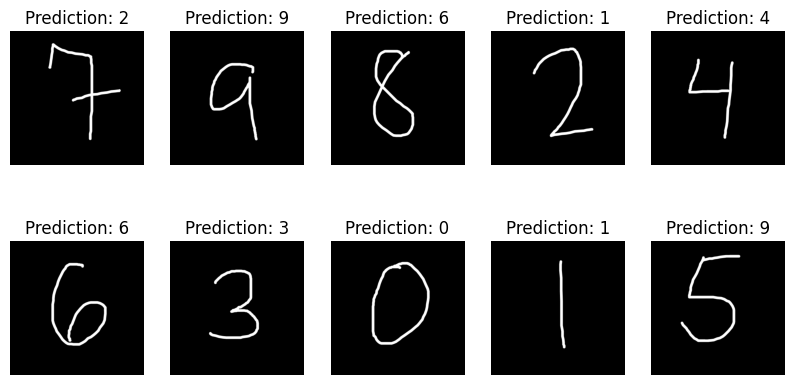

In [16]:
scripted_module = torch.jit.load('models/checkpoints/mnist-vit-best-acc.pt')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((28,28)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Grayscale(num_output_channels=1)])

patch_num = 4
# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/digit0.png'), 
        Image.open('digits/digit1.png'),
        Image.open('digits/digit2.png'),
        Image.open('digits/digit3.png'),
        Image.open('digits/digit4.png'),
        Image.open('digits/digit5.png'),
        Image.open('digits/digit6.png'),
        Image.open('digits/digit7.png'),
        Image.open('digits/digit8.png'),
        Image.open('digits/digit9.png')]

for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = rearrange(img, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=patch_num, p2=patch_num)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")

However, as we made the handwriting of the digits thicker, we see a significant boost in its performance as it now predicts all digits correctly.

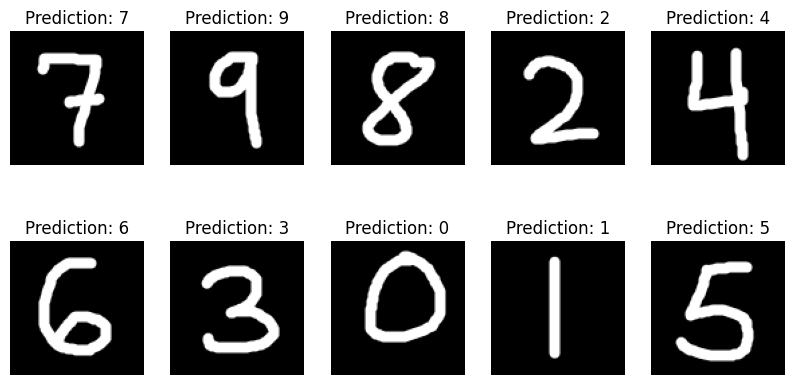

In [17]:
# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/digit10.png'), 
        Image.open('digits/digit11.png'),
        Image.open('digits/digit12.png'),
        Image.open('digits/digit13.png'),
        Image.open('digits/digit14.png'),
        Image.open('digits/digit15.png'),
        Image.open('digits/digit16.png'),
        Image.open('digits/digit17.png'),
        Image.open('digits/digit18.png'),
        Image.open('digits/digit19.png')]
        
for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = rearrange(img, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=patch_num, p2=patch_num)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")

To confirm if the vision transformer considers the position of the image patches through positional embedding, we look at its performance if the patches are shuffled. We observe that, although the images used are still the same, the model cannot predict the class correctly when the patches are shuffled. Thus, we can confirm that the positional embedding of our ViT model is useful. 

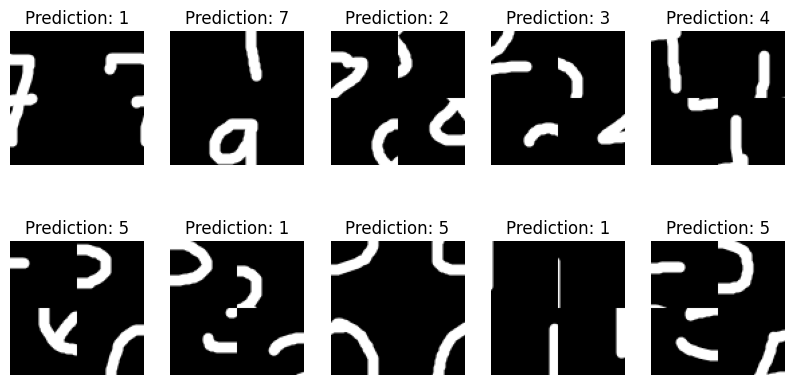

In [5]:
# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

imgs = [Image.open('digits/shuffled_digit10.png'), 
        Image.open('digits/shuffled_digit11.png'),
        Image.open('digits/shuffled_digit12.png'),
        Image.open('digits/shuffled_digit13.png'),
        Image.open('digits/shuffled_digit14.png'),
        Image.open('digits/shuffled_digit15.png'),
        Image.open('digits/shuffled_digit16.png'),
        Image.open('digits/shuffled_digit17.png'),
        Image.open('digits/shuffled_digit18.png'),
        Image.open('digits/shuffled_digit19.png')]
        
for i, img in enumerate(imgs):
    img = img.convert('RGB')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    img = transform(img)
    img = torch.unsqueeze(img,0)
    img = rearrange(img, 'b c (p1 h) (p2 w) -> b (p1 p2) (c h w)', p1=patch_num, p2=patch_num)
    img = img.to('cuda')
    y_hat = scripted_module(img)
    y_pred = torch.argmax(y_hat, dim=1)[0]
    plt.title(f"Prediction: {y_pred}")